***
# ***Part 0 - Preparing the environment***
***
Before we start, we import the necessary libraries for the analysis and create a color palette for the plots.

In [75]:
# Importing the required libraries for all parts of the project
import numpy as np                                  # For numerical operations        
import matplotlib.pyplot as plt                     # For plotting graphs
from scipy.optimize import root_scalar              # For solving non-linear equations
import copy                                         # For copying objects    
from matplotlib.ticker import PercentFormatter      # For formatting y-axis in percentage
from numpy.polynomial.hermite_e import hermegauss   # For Gauss-Hermite quadrature

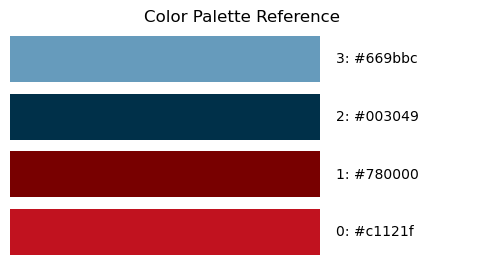

In [76]:
# Color palette for the plots
colors = ['#c1121f', '#780000','#003049','#669bbc']

# Plotting the color palette for easy reference
plt.figure(figsize=(6, 3))
for i, color in enumerate(colors):
    _ = plt.barh(y=i, width=1, color=color)
    _ =plt.text(x=1.05, y=i, s=f"{i}: {color}", va='center')

# Adjust plot limits and turn off axes
plt.ylim(-0.5, len(colors) - 0.5)
plt.xlim(0, 1.5)
plt.axis("off")
_ = plt.title("Color Palette Reference")

***
# ***Part 1 - Euler equation erros***
***

In [77]:
# Import dataclass from the dataclasses module
from dataclasses import dataclass

# Define a data class to store Parameters
@dataclass
class Parameters:
    """
    Parameters for the overlapping generations model (OLG)
    """
    # Part 1 - 3 - OLG Model Parameters
    beta: float = 0.96**30              # Discount factor
    gamma: float = 5.0                  # Relative risk aversion
    alpha: float = 0.36                 # Capital share of output (production)
    delta: float = 1 - 0.94**30         # Capital depreciation
    z: float = 1.0                      # Total factor productivity (TFP)
    
    # Part 4 - PAYGO system
    tau: float = 0.0                    # Payroll tax rate (Default is  0.0 --> No PAYGO system)
    
    # Part 5 - AR (1) Parameters
    rho: float = 0.95**30               # Autocorrelation 
    sigma_2: float = 0.05**2            # Conditional variance 
    mu: float = -1/2*sigma_2/(1 + rho)  # Conditional mean

    epsilon_grid: np.ndarray = None     # Discretized shock values
    epsilon_prob: np.ndarray = None     # Corresponding probabilities

# Create two instances of the Parameters class
par = Parameters()                      # tau = 0.0
par_paygo = Parameters(tau=0.1)         # tau = 0.1

In [78]:
# Define a function to map k to factor prices r and w using the first-order conditions
def compute_prices(k, par: Parameters, z = None):
    """
    Return factor prices for a given capital-labor ratio and parameters.

    Parameters
    ----------
    k : float
        Capital-labor ratio.
    par : Parameters
        Instance of the Parameters class including model parameters for the OLG model.
    z : float, optional
        Total factor productivity. If not provided, par.z will be used.

    Returns
    -------
    r : float
        Return on capital after depreciation (interest rate)
    w : float
        Wage rate
    """
    # Use par.z if no z is provided
    if z is None:
        z = par.z
    
    # Return on capital after depreciation (interest rate)
    r = par.alpha * z * k ** (par.alpha - 1) - par.delta

    # Wage rate
    w = (1 - par.alpha) * z * k**par.alpha

    return r, w

In [79]:
# Define a function to compute the Euler equation error
def euler_err(k_next, k, par: Parameters):
    """
    Compute the Euler equation error for a given capital stock today and tomorrow.

    Parameters
    ----------
    k_next : float
        Capital in the next period.
    k : float
        Capital in the current period.
    par : Parameters
        An instance of the Parameters class.

    Returns
    -------
    float
        Euler equation error.
    """
    # Compute factor prices for the todays period
    _, w = compute_prices(k, par)

    # Compute factor prices for the next period
    r_next, w_next = compute_prices(k_next, par)

    # Asset market clearing condition
    a = k_next

    # Pension paymets
    p_next = par.tau * w_next

    # Consumption by the young
    c_y = (1 - par.tau) * w - a
    # Consumption by the old
    c_o = (1 + r_next) * a + p_next

    # Left-hand side of the Euler equation
    lhs = c_y ** (-par.gamma)

    # Right-hand side of the Euler equation
    rhs = par.beta * (1 + r_next) * (c_o ** (-par.gamma))

    # Euler equation error
    err = lhs - rhs

    return err

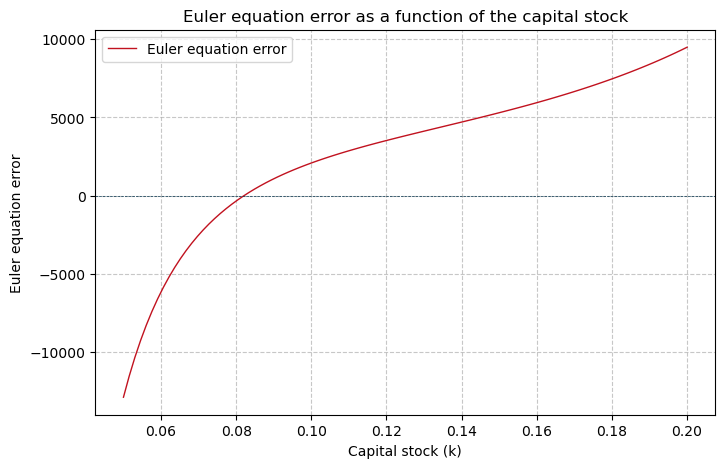

In [80]:
# Create a grid of capital values, k, on the interval [0.05, 0.2]
k_gird = np.linspace(0.05, 0.2, 100)

# Create an empty array to store the Euler equation error
euler_err_grid = np.empty_like(k_gird)

# Compute the Euler equation error for each value of k assuming k_next = k
euler_err_grid = euler_err(k_gird, k_gird, par)

# Plot the Euler equation error as a function of the capital stock
plt.figure(figsize=(8, 5))
plt.plot(k_gird, euler_err_grid, c=colors[0], lw=1, label="Euler equation error")
plt.axhline(0, c=colors[2], ls="--", lw=0.5)
plt.xlabel("Capital stock (k)")
plt.ylabel("Euler equation error")
plt.title("Euler equation error as a function of the capital stock")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)


### **Why is the graph upward sloping?**
The plot illustrates the Euler equation error as a function of the capital stock, $k$. The function has a root where the error equals zero, indicating a steady-state equilibrium where the household’s intertemporal optimization condition holds. The graph is upward sloping because the Euler equation error reflects the difference between the marginal utility of consumption when young and the discounted marginal utility of consumption when old. At low capital levels, savings are insufficient to smooth consumption optimally, leading to a large negative error. As capital increases, future consumption improves, reducing the error. Eventually, the function crosses the zero line, confirming the existence of a steady-state solution where the intertemporal condition is satisfied. Beyond this point, excessive capital leads to higher savings and lower consumption in youth, pushing the Euler equation error into positive territory.
 


***
# ***Part 2 - Steady state***
***

In [81]:
# Defina a data class to store the steady state quantities and prices
@dataclass
class SteadyState:
    par: Parameters = None          # Parameters used to compute equilibrium
    c_y: float = None               # Consumption when young
    c_o: float = None               # Consumption when old
    a: float = None                 # Savings when young
    s: float = None                 # Savings rate when young
    r: float = None                 # Interest rate (return on capital)
    w: float = None                 # Wage rate
    K: float = None                 # Aggregate capital stock
    L: float = None                 # Aggregate labor demand
    I: float = None                 # Aggregate investment
    Y: float = None                 # Aggregate output

In [82]:
# Define a function to compute the steady state equilibrium using root finding
def compute_steady_state(par: Parameters):
    """
    Compute the steady-state equilibrium for the OLG model.

    Parameters
    ----------
    par : Parameters
        Parameters for the given problem

    Returns
    -------
    eq : SteadyState
        Steady state equilibrium of the OLG model
    """
    # Solve for the equilibrium capital stock using root finding
    res = root_scalar(
        lambda k: euler_err(k, k, par),     # k_next = k
        bracket=(0.01, 0.2),                # search interval
    )

    if not res.converged:
        print("Equilibrium root-finder did not converge.")

    # Equilibrium capital stock
    K = res.root

    # Create instance of SteadyState with explicit L
    eq = SteadyState(par=par, K=K, L=1)

    # Compute the equilibrium factor prices
    eq.r, eq.w = compute_prices(eq.K / eq.L, par)

    # Investment in steady state
    eq.I = (eq.K * par.delta)  # Since we assume k_next = k --> I = k_next - (1-delta)k = k(1 - (1 - delta)) = k*delta

    # Asset market clearing condition
    eq.a = eq.K 
    
    # Savings rate
    eq.s = eq.a / ((1-par.tau) * eq.w)
    
    # Pension payments
    p = par.tau * eq.w

    # Compute consumption when young and old
    eq.c_y = (1 - par.tau) * eq.w - eq.a
    eq.c_o = (1 + eq.r) * eq.a + p

    # Compute output (Include L even though it is 1)
    eq.Y = par.z * eq.K**par.alpha * eq.L ** (1 - par.alpha)
    
    # Goods market clearing
    demand = eq.c_y + eq.c_o + eq.a
    supply = eq.Y + (1 - par.delta) * eq.K
    GMC = abs(demand - supply)  # Should be close to zero

    # Check that goods market clearing holds using an assertion
    assert (GMC < 1.0e-6)  # Assert that the difference is less than 1.0e-6

    return eq

In [83]:
# Function to print the steady state equilibrium
def print_steady_state(eq: SteadyState):
    """
    Print equilibrium prices, allocations, and excess demand.

    Parameters
    ----------
    eq : SteadyState
        SteadyState of the OLG model
    """
    print("Steady-state equilibrium:")
    print(f"------------------------------------------------")
    print("  Households:")
    print(f"    Consumption when young (c_y) =  {eq.c_y:.5f}")
    print(f"    Consumption when old (c_o) =    {eq.c_o:.5f}")
    print(f"    Savings (a) =                   {eq.a:.5f}")
    print(f"    Savings rate (s) =              {eq.s:.5f}")
    print(f"------------------------------------------------")
    print("  Firms:")
    print(f"    Capital (K) =                   {eq.K:.5f}")
    print(f"    Labor (L) =                     {eq.L:.5f}")
    print(f"    Output (Y) =                    {eq.Y:.5f}")
    print(f"------------------------------------------------")
    print("  Prices:")
    print(f"    Interest rate (r) =             {eq.r:.5f}")
    print(f"    Wage rate (w) =                 {eq.w:.5f}")
    print(f"------------------------------------------------")
    print("  Market Clearing Conditions:")
    print(f"    Capital market:                 {abs(eq.K - eq.a):.2e}")
    print(f"    Goods market:                   {abs((eq.c_y + eq.c_o + eq.a) - eq.Y - (1-eq.par.delta) * eq.K):.2e}")
    print(f"------------------------------------------------")

In [84]:
# Compute the steady state equilibrium
eq = compute_steady_state(par)

# Print the steady state equilibrium
print_steady_state(eq)

Steady-state equilibrium:
------------------------------------------------
  Households:
    Consumption when young (c_y) =  0.17812
    Consumption when old (c_o) =    0.15918
    Savings (a) =                   0.08206
    Savings rate (s) =              0.31541
------------------------------------------------
  Firms:
    Capital (K) =                   0.08206
    Labor (L) =                     1.00000
    Output (Y) =                    0.40653
------------------------------------------------
  Prices:
    Interest rate (r) =             0.93963
    Wage rate (w) =                 0.26018
------------------------------------------------
  Market Clearing Conditions:
    Capital market:                 0.00e+00
    Goods market:                   6.94e-18
------------------------------------------------


### **Comment:**

The steady-state equilibrium has been computed and verified using both the Euler equation condition and the goods market clearing condition. The results show that:

- <ins>*Goods Market Clearing:*</ins>  
  The difference between aggregate output & undepreciated capital (supply) and the sum of goods consumed by the young and old, along with the investment by the young (demand), is effectively zero ($4.86e-17$).

- <ins>*Capital Market Clearing:*</ins>  
The capital market clearing condition is met, as the difference between household savings ($a$) and capital ($K$) is approximetly zero ($1.39e-17$) This ensures that the supply of savings matches the demand for capital investment.

- <ins>*Full Allocation:*</ins>  
  By Walras’ Law, total production is fully allocated.

The table above presents the equilibrium quantities and prices.


***
# ***Part 3 - Transition Dynamics***
***

In [85]:
# Define a data class to store the simulated time series
@dataclass
class Simulation:
    """
    Stores time series data for transition dynamics.
    """
    c_y: np.ndarray = None          # Time series for consumption when young
    c_o: np.ndarray = None          # Time series for consumption when old
    a: np.ndarray = None            # Time series for savings when young
    s: np.ndarray = None            # Time series for savings rate when young
    r: np.ndarray = None            # Time series for interest rate (return on capital)
    w: np.ndarray = None            # Time series for wages
    K: np.ndarray = None            # Time series for aggregate capital stock
    Y: np.ndarray = None            # Time series for aggregate output
    z: np.ndarray = None            # Time series for TFP
    tau: np.ndarray = None          # Time series for payroll tax rate

In [86]:
# Define a function to initialize the simulation and allocate arrays for time series
def initialize_sim(T, eq: SteadyState = None):
    """
    Initialize simulation instance (allocate arrays for time series).

    Parameters
    ----------
    T : int
        Number of periods to simulate
    eq : SteadyState, optional
        Steady-state equilibrium to use for initial period
    """
    # Initialize simulation instance
    sim = Simulation()

    # Initialize time series arrays
    sim.c_y = np.zeros(T + 2)
    sim.c_o = np.zeros(T + 2)
    sim.a = np.zeros(T + 2)
    sim.s = np.zeros(T + 2)
    sim.r = np.zeros(T + 2)
    sim.w = np.zeros(T + 2)
    sim.K = np.zeros(T + 2)
    sim.Y = np.zeros(T + 2)
    sim.z = np.zeros(T + 2)
    sim.tau = np.zeros(T + 2)

    # If eq is provided, set initial values to steady state
    if eq is not None:
        sim.c_y[0] = eq.c_y
        sim.c_o[0] = eq.c_o
        sim.a[0] = eq.a
        sim.s[0] = eq.s
        sim.r[0] = eq.r
        sim.w[0] = eq.w
        sim.K[0] = eq.K
        sim.Y[0] = eq.Y
        sim.z[0] = eq.par.z
    
    # Start the economy withou a PAYGO system
    sim.tau[0] = 0.0

    return sim

In [87]:
# Define a function to simulate the transition dynamics of the OLG model
def simulate_olg(K1, T, eq: SteadyState, par: Parameters):
    """
    Simulate the transition dynamics of the OLG model starting from steady state
    when a shock to capital realizes in period 1.

    Parameters
    ----------
    K1 : float
        Initial capital stock in period 1.
    T : int
        Number of periods to simulate.
    eq : SteadyState
        Initial steady-state equilibrium of the OLG model before the shock.
    par : Parameters
        Model parameters including PAYGO system.

    Returns
    -------
    sim : Simulation
        Simulation object containing the time series for each variable.
    """

    par_sim = copy.copy(par)                # Copy parameters to avoid modifying the original
    sim = initialize_sim(T, eq)             # Initialize simulation structure
    sim.K[1] = K1                           # Set the capital stock in period 1 (Optional shock)
    sim.z[:] = par_sim.z                    # Set the TFP to initial value for all periods

    # Iterate over time periods
    for t in range(1, T + 1):

        # Dynamically choose root-finding interval based on previous period's capital
        low_k = 0.1 * sim.K[t]              # 10% of previous capital 
        high_k = 2.0 * sim.K[t]             # 200% of previous capital 

        # Solve for k_next by finding the root of the Euler error
        res = root_scalar(lambda k_next: euler_err(k_next, sim.K[t], par_sim),
            bracket=(low_k, high_k),)

        if not res.converged:
            print(f"WARNING: Root-finding failed at t={t}, using fallback value")
            
        # Update capital stock
        sim.K[t + 1] = res.root
        
        # Asset market clearing
        sim.a[t] = sim.K[t + 1] 
            
        # Update interest rate and wage rate
        sim.r[t], sim.w[t] = compute_prices(sim.K[t], par_sim)
        
        # Calculate savings rate
        sim.s[t] = sim.a[t] / ((1 - par_sim.tau) * sim.w[t]) # Where the denominator is the income of the young
        
        # Update tau, calculate output and s
        sim.tau[t] = par_sim.tau  # Purpose: To keep track of the PAYGO system
        sim.Y[t] = sim.z[t] * sim.K[t] ** par_sim.alpha  # Production (L=1)
        
        if t > 1: # In t = 1 a[t-1] not equal k[t] because we have a shock in period 1 
                  # Instead of only asserting when t > 1 you could also change sim.a[t-1] to k[t]
                  # in the computation of c_o[t] to assert for t = 1 as well
            
            # Compute pension payments
            p = par_sim.tau * sim.w[t]
            
            # Compute consumption when young and old
            sim.c_y[t] = (1 - par_sim.tau) * sim.w[t] - sim.a[t]
            sim.c_o[t] = (1 + sim.r[t]) * sim.a[t - 1] + p  # Note: Here we calculate c_0(t) not c_0(t+1), meaning we use a[t-1] and not r(t+1) as we did in the Euler error function

            # Check goods market clearing
            demand = sim.c_y[t] + sim.c_o[t] + sim.a[t]
            supply = sim.Y[t] + (1 - par_sim.delta) * sim.K[t]
            GMC = abs(demand - supply)

            assert (GMC < 1.0e-6)  # Assert that the difference is less than 1.0e-6
        
    return sim

In [88]:
# Parameters for the simulation
K1 = eq.K / 2       # Shock: Assuming the capital falls to half of steady state in period 1
T = 20              # Number of periods to simulate

In [89]:
# Simulate the transition dynamics for T = 20 periods --> [0, 1, 2, ..., 20] meaning 21 values
sim = simulate_olg(K1, T, eq = eq, par = par)

In [90]:
# Define a function to plot the simulated time series
def plot_simulation(eq, sim, eq_new=None, deviations=True, filename=None):
    """
    Plot the simulated time series for Y, K, w, r, s in a 3x2 grid.
    The first three (Y, K, w) are shown as percent deviations from their
    initial steady-state values if deviations=True. The last two (r, s)
    are shown in levels.

    Parameters
    ----------
    eq : SteadyState
        Initial steady-state equilibrium. Used for reference lines
        and to compute deviations if 'deviations=True'.
    sim : Simulation
        The simulation object containing time series data.
    eq_new : SteadyState, optional
        If provided, also plot a dashed horizontal line for the
        new steady-state level in each subplot.
    deviations : bool, default True
        If True, plot Y, K, w as % deviations from the old steady state;
        if False, plot them in levels.
    filename : str, optional
        If provided, the figure is saved to this file.
    """
    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True)

    # Keyword arguments for the main time-series plots
    kwargs_line = {
        "marker": "o" if len(sim.Y) < 30 else None,
        "markersize": 4,
        "color": colors[0],
        "label": "Simulation",
    }

    # Keyword arguments for the old (initial) steady-state lines
    kwargs_init = {
        "color": colors[2],
        "linewidth": 0.8,
        "linestyle": "--",
        "label": "Steady State" if eq_new is not None else "Initial SS",
    }

    # Keyword arguments for the new steady-state lines
    kwargs_new = {
        "color": colors[3],
        "linewidth": 0.8,
        "linestyle": "--",
        "label": "New SS",
    }
    # ------------------------------------------------------
    # 0) Preparation: Deviations and smoothing functions
    # ------------------------------------------------------

    # Define a function to compute % deviations
    def pct_dev(series, ss_value):
        """
        Compute percent deviations of series from ss_value.

        Parameters
        ----------
        series : array-like
            The series to compute deviations for.
        ss_value : float
            The steady-state value to compute deviations from.

        Returns
        -------
        array-like
            Percent deviations of series from ss_value.
        """
        if deviations:
            return 100 * (series / ss_value - 1)
        else:
            return series

    # Smooth series to correct for numerical floating point errors
    def smooth_series(series, threshold=1e-6):
        """
        Snap series[i] to series[i-1] if their difference
        is below threshold.

        Parameters
        ----------
        series : array-like
            The series to smooth.
        threshold : float, optional
            The threshold below which to snap values together.
        Returns
        -------
        array-like
            The smoothed series.
        """
        for i in range(1, len(series)):
            if abs(series[i] - series[i - 1]) < threshold:
                series[i] = series[i - 1]
        return series

    # ------------------------------------------------------
    # 1) Smooth all simulation series and remove one period
    # ------------------------------------------------------
    sim.Y = smooth_series(sim.Y, threshold=1e-6)
    sim.K = smooth_series(sim.K, threshold=1e-6)
    sim.w = smooth_series(sim.w, threshold=1e-6)
    sim.r = smooth_series(sim.r, threshold=1e-6)
    sim.s = smooth_series(sim.s, threshold=1e-6)
    
    # Remove the last period to avoid plotting values for T+1 (which have multiple zero-values)
    Y_plot = sim.Y[:-1]
    K_plot = sim.K[:-1]
    w_plot = sim.w[:-1]
    r_plot = sim.r[:-1]
    s_plot = sim.s[:-1]
    z_plot = sim.z[:-1]

    # ------------------------------------------------------
    # 2) Y_t: % dev if deviations = True, else level
    # ------------------------------------------------------
    ax = axes[0, 0]
    yvals = pct_dev(Y_plot, eq.Y)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.Y
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.Y
        if deviations:
            ref_line_new = 100 * (eq_new.Y / eq.Y - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$Y_t$")
    ax.set_ylabel("Deviations from initial SS" if deviations else "Level")

    # ------------------------------------------------------
    # 3) K_t: % dev if deviations=True, else level
    # ------------------------------------------------------
    ax = axes[0, 1]
    yvals = pct_dev(K_plot, eq.K)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.K
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.K
        if deviations:
            ref_line_new = 100 * (eq_new.K / eq.K - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$K_t$")

    # ------------------------------------------------------
    # 4) w_t: % dev if deviations=True, else level
    # ------------------------------------------------------
    ax = axes[1, 0]
    yvals = pct_dev(w_plot, eq.w)
    ax.plot(yvals, **kwargs_line)
    # Steady-state reference line
    ref_line = 0 if deviations else eq.w
    ax.axhline(ref_line, **kwargs_init)
    # If new SS is provided
    if eq_new is not None:
        ref_line_new = 0 if deviations else eq_new.w
        if deviations:
            ref_line_new = 100 * (eq_new.w / eq.w - 1)
        ax.axhline(ref_line_new, **kwargs_new)
    ax.set_title(r"$w_t$")
    ax.set_ylabel("Deviations from initial SS" if deviations else "Level")

    # ------------------------------------------------------
    # 5) r_t (always in levels)
    # ------------------------------------------------------
    ax = axes[1, 1]
    ax.plot(r_plot, **kwargs_line)
    ax.axhline(eq.r, **kwargs_init)
    if eq_new is not None:
        ax.axhline(eq_new.r, **kwargs_new)
    ax.set_title(r"$r_t$ (levels)")
    ax.set_xlabel("Period")
    ax.tick_params(axis="x", labelbottom=True)

    # ------------------------------------------------------
    # 6) s_t (always in levels)
    # ------------------------------------------------------
    ax = axes[2, 0]
    ax.plot(s_plot, **kwargs_line)
    ax.axhline(eq.s, **kwargs_init)
    if eq_new is not None:
        ax.axhline(eq_new.s, **kwargs_new)
    ax.set_title(r"$s_t$ (levels)")
    ax.set_xlabel("Period")
    ax.set_ylabel("Level")
    
    # ------------------------------------------------------
    # 7) z_t (always in levels)
    # ------------------------------------------------------
    if np.all(sim.z == eq.par.z):
        axes[2, 1].axis("off")
    else:
        ax = axes[2, 1]
        ax.plot(z_plot, **kwargs_line)
        ax.axhline(eq.par.z, **kwargs_init)
        if eq_new is not None:
            ax.axhline(eq_new.par.z, **kwargs_new)
        ax.set_title(r"$z_t$ (levels)")
        ax.set_xlabel("Period")
        ax.set_ylabel("Level")

    # ------------------------------------------------------
    # 8) Apply settings common to all axes
    # ------------------------------------------------------

    # Apply settings common to all axes
    if deviations:
        # Format the first three subplots as percent
        for row, col in [(0, 0), (0, 1), (1, 0)]:
            axes[row, col].yaxis.set_major_formatter(PercentFormatter(decimals=0))

    axes[0, 0].legend(loc="right")
    fig.tight_layout()

    # Optional save
    if filename:
        plt.savefig(filename)

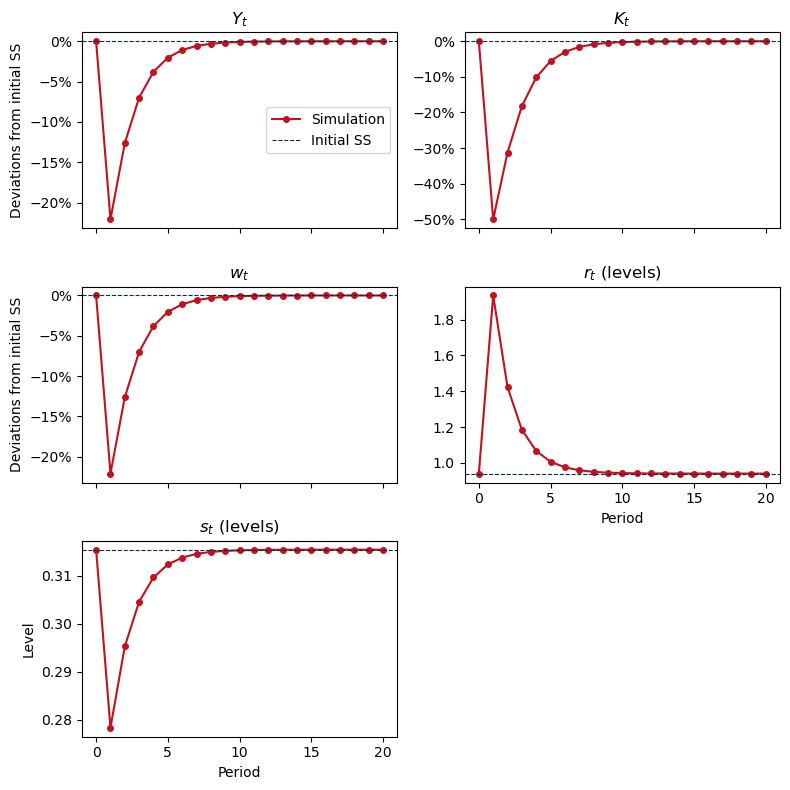

In [91]:
# Plot the transition dynamics of the OLG model
plot_simulation(eq, sim)  # No new steady state

### **Explanation of the results**
The plots illustrate the transition dynamics of key economic variables following a shock that initially moves the economy away from its steady state. The top-left panel shows output ($Y_t$), which initially drops before converging back to its steady-state level, reflecting the economy's response to lower capital availability. The top-right panel presents the capital stock ($K_t$), which experiences a sharp initial decline of 50% but gradually recovers, as agents accumulate savings over time. The middle-left panel shows the wage rate ($w_t$), which follows a similar pattern to output, as wages are directly linked to labor productivity and capital. The middle-right panel displays the interest rate ($r_t$), which spikes initially due to the lack of capital but declines as capital accumulation resumes, stabilizing near its steady-state level. Finally, the bottom-left panel shows the savings rate ($s_t$), which initially drops before increasing, demonstrating agents' forward-looking behavior in response to the temporary shock. These dynamics are consistent with standard overlapping generations (OLG) models, where the economy gradually converges to a steady state as households and firms adjust their savings and investment decisions.


***
# ***Part 4 - Pay-as-you-go (PAYGO) pension system***
***

To implement the PAYGO pension system, we modified the `euler_err()`, `compute_steady_state()`, `initialize_sim()` and `simulate_olg()` by introducing a payroll tax, $\tau$, which reduces the disposable income of the young while providing pension benefits to the old. Specifically, in these equations (except `initilaize_sim()`, where we added a new array to the simulation) we adjusted consumption as follows:

- <ins>Young households:</ins> Disposable income is now $(1 - \tau)w$, reducing the amount available for savings.

- <ins>Old households:</ins> Receive an additional pension transfer equal to $\tau w$, supplementing their retirement income.

In [92]:
# Compute the new steady state equilibrium
eq_paygo = compute_steady_state(par_paygo) # par_paygo, where tau = 0.1

# Print the new steady state equilibrium
print_steady_state(eq_paygo)

Steady-state equilibrium:
------------------------------------------------
  Households:
    Consumption when young (c_y) =  0.13954
    Consumption when old (c_o) =    0.13670
    Savings (a) =                   0.03809
    Savings rate (s) =              0.21442
------------------------------------------------
  Firms:
    Capital (K) =                   0.03809
    Labor (L) =                     1.00000
    Output (Y) =                    0.30837
------------------------------------------------
  Prices:
    Interest rate (r) =             2.07106
    Wage rate (w) =                 0.19736
------------------------------------------------
  Market Clearing Conditions:
    Capital market:                 0.00e+00
    Goods market:                   1.73e-18
------------------------------------------------


### **PAYGO system effect on the savings rate and capital stock**
In a pay‐as‐you‐go (PAYGO) system, today’s young workers are taxed and that revenue goes to pay pensions for the currently old. Because young households anticipate that they will receive a pension when they’re old, they have less incentive to save on their own, lowering the savings rate ($s$).

Less saving by the young directly translates to a smaller stock of capital ($K$) in the next period’s production. The intuitive reason is straightforward: if the government guarantees some pension benefit, each household does not need to put aside as much of its own income, so the total (private) capital accumulation falls.

When the PAYGO system reduces households’ private saving and thereby the aggregate capital stock, the marginal product of capital rises (since capital is now scarcer). Because the interest rate ($r$) is closely tied to the marginal productivity of capital, the lower capital stock leads to a higher steady‐state interest rate.

In short:

Lower capital stock ⟹ Higher marginal product of capital ⟹ Higher $r$

In [93]:
# Simulate the transition dynamics for T = 20 periods
sim_olg_pension = simulate_olg(eq.K, T, eq = eq, par = par_paygo)  # No shock in capital, T = 20 is the same as before

In [94]:
# Verify that tau is updated in the simulation
print(sim_olg_pension.tau)

[0.  0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0. ]


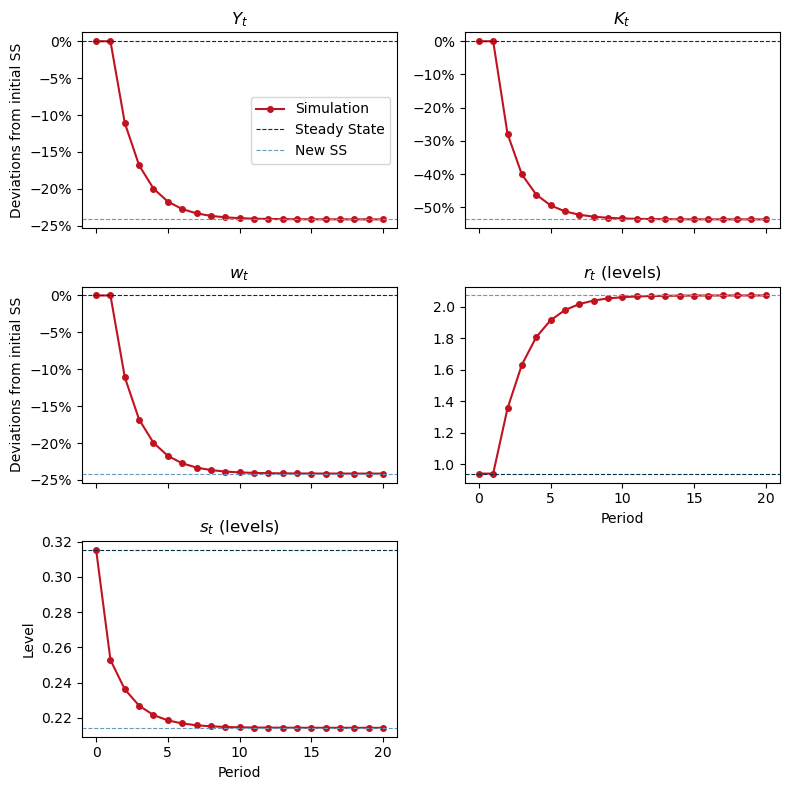

In [95]:
# Plot the transition dynamics of the OLG model with PAYGO system
plot_simulation(eq, sim_olg_pension, eq_paygo)


### **Explanation of the results**
The plots illustrate the economy's adjustment process following the introduction of PAYGO, showing the transition from the initial steady state to the new steady state over 20 periods:

- Capital Stock ($K_t$): The capital stock declines sharply, approaching a level about 50% lower than the initial SS due to reduced savings.
- Output ($Y_t$): Follows a similar trajectory as capital, declining by approximately 25% before stabilizing at the new SS.
- Wage Rate ($w_t$): Declines over time due to lower capital per worker, reflecting decreased marginal productivity of labor.
- Interest Rate ($r_t$): Increases sharply before stabilizing at a higher level, as the capital-labor ratio decreases and borrowing becomes more expensive.
- Savings Rate ($s_t$): Drops momentarily as the tax is introduced in the early periods and converges to a lower long-run level, as households rely more on pension benefits and reduce savings. This behavior is due to the *perfect foresight assumptions*, where households know the future path of interest rates after a shock hits the economy. 
 
These dynamics highlight how PAYGO reduces the need for private savings while shifting part of old-age consumption financing from capital accumulation to cross-generational transfers. Over time, the economy converges smoothly to the new steady state as individuals adjust their consumption and savings behavior accordingly.



***
# ***Part 5 - TFP as an AR(1)***
***

In [96]:
epsilon_grid, epsilon_prob = hermegauss(5)      # Get Gauss-Hermite nodes and weights
epsilon_prob /= np.sqrt(2 * np.pi)              # Normalize probabilities

# Assign for both instances of the Parameters class (par and par_paygo)
par.epsilon_grid = epsilon_grid                 # Assign nodes to the Parameters instance
par.epsilon_prob = epsilon_prob                 # Assign weights to the Parameters instance
par_paygo.epsilon_grid = epsilon_grid           # Assign nodes to the Parameters instance
par_paygo.epsilon_prob = epsilon_prob           # Assign weights to the Parameters instance

In [97]:
# Simulate the AR(1) process for TFP
def simulate_ar1(z0, T, seed, par: Parameters):
    """
    Simulate an AR(1) process for TFP.

    Parameters
    ----------
    z0 : float
        Initial TFP value.
    T : int
        Number of periods to simulate.
    seed : int
        Seed for the random number generator.
    par : Parameters
        An instance of the Parameters class containing additional AR(1) parameters:
          - par.mu        (float): Intercept in the log-AR(1)
          - par.rho       (float): Persistence parameter in the log-AR(1)
          - par.sigma_2   (float): Variance of the log-AR(1) innovation
          - par.epsilon_grid (np.ndarray): Discrete support for shocks
          - par.epsilon_prob (np.ndarray): Probabilities for each shock in epsilon_grid

    Returns
    -------
    np.ndarray
        Array (length T+1) of simulated TFP values.
    """
    # Create an array to store the simulated TFP values
    z = np.zeros(T + 2) 
    
    # Set the initial value of TFP
    z[0] = z0 
    
    # Create a RNG instance
    rng = np.random.default_rng(seed=seed)
    
    # Simulate the AR(1) process over time
    for t in range(T + 1):
        # Draw one shock from the discrete approximation
        epsilon = rng.choice(par.epsilon_grid, p=par.epsilon_prob)
        
        # Update log of TFP
        log_z = (par.mu + par.rho * np.log(z[t]) + np.sqrt(par.sigma_2) * epsilon) # PS: If sigma = 0, then log_z = 0, then z =1

        # Convert log TFP back to levels
        z[t + 1] = np.exp(log_z)

    return z


In [98]:
# Parameters for the test
z0 = eq_paygo.par.z     # Steady state TFP value 
T = 100_000             # Number of periods
seed = 1234             # Random seed for reproducibility

Mean TFP (Expected ≈ 1.0): 0.99995


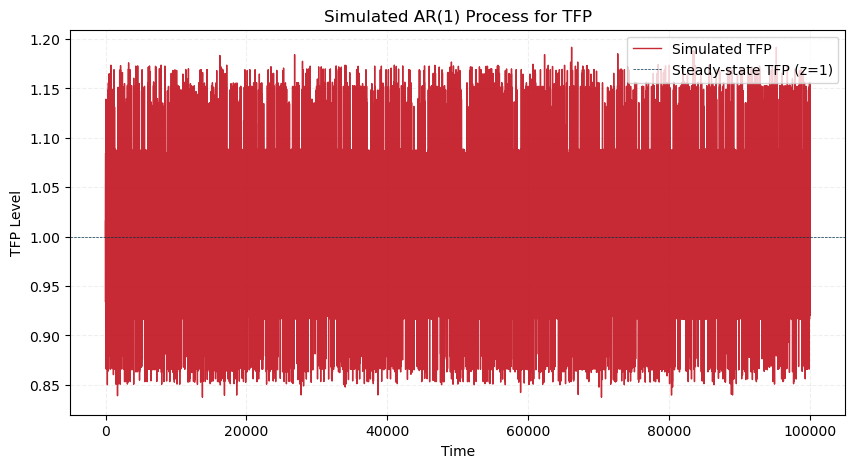

In [99]:
# Simulate TFP time series
tfp_sim = simulate_ar1(z0, T, seed, par)

# Compute the mean of simulated TFP values
tfp_mean = np.mean(tfp_sim)

# Plot the simulated TFP series
plt.figure(figsize=(10, 5))
plt.plot(tfp_sim, label="Simulated TFP", alpha=0.9, c = colors[0], lw=1)
plt.axhline(1, c = colors[2], linestyle='--', lw=0.5, label="Steady-state TFP (z=1)")
plt.xlabel("Time")
plt.ylabel("TFP Level")
plt.title("Simulated AR(1) Process for TFP")
plt.grid(True, linestyle="--", alpha=0.2)
plt.legend(loc = 'upper right')

# Expected Mean TFP value
print(f"Mean TFP (Expected ≈ 1.0): {tfp_mean:.5f}")

### **Explanation of the results**
The simulation of the Total Factor Productivity (TFP) process follows an AR(1) process, where TFP fluctuates around its steady-state value of $z = 1$. The reported mean TFP is $0.99995$, which is close to the expected theoretical value of $1.0$, confirming that the stochastic process is correctly specified. The plot shows that while TFP exhibits significant short-term variations, it remains centered around the steady-state level over the long run, consistent with the properties of a AR(1) process. 

***
# ***Part 6 - OLG model with aggregate risk***
***

In [100]:
# Modify the euler_err function so that TFP follows an AR(1) process
def euler_err_ar1(k_next, k, z, par: Parameters):
    """
    Compute the Euler equation error if log TFP follows an AR(1) process.

    Parameters
    ----------
    k_next : float
        Capital in the next period.
    k : float
        Capital in the current period.
    z : float
        TFP in the current period.
    par : Parameters
        An instance of the Parameters class.
        
    Returns
    -------
    float
        Euler equation error.
    """
    # Left-hand side of the Euler equation
    _, w = compute_prices(k, par, z)        # Compute factor prices for the todays period
    a = k_next                              # Asset market clearing condition
    c_y = (1 - par.tau) * w - a             # Consumption by the young
    lhs = c_y ** (-par.gamma)               # Left hand side
    
    # Right-hand side of the Euler equation
    expected_rhs = 0                        # Set initial value for expected RHS
    
    for eps, prob in zip(par.epsilon_grid, par.epsilon_prob):
        # Next-period TFP from AR(1)
        log_z_next = par.mu + par.rho * np.log(z) + np.sqrt(par.sigma_2)*eps
        z_next = np.exp(log_z_next)

        # Factor prices next period
        r_next, w_next = compute_prices(k_next, par, z_next)  # Compute factor prices for the next period

        p_next = par.tau * w_next           # pension
        c_o = (1 + r_next) * a + p_next     # Consumption by the old

        # Next-period marginal utility term
        rhs_component = (1 + r_next) * (c_o ** (-par.gamma)) 

        # Weight by probability and sum
        expected_rhs += prob * rhs_component

    # Multiply by discount factor
    rhs = par.beta * expected_rhs

    # Euler equation error
    err = lhs - rhs
    
    return err

In [101]:
# Define a function to simulate the transition dynamics of the OLG model
def simulate_olg_ar1(K0, z_series, par: Parameters):
    """
    Simulate the transition dynamics of the OLG model staring for given initial
    capital.

    Parameters
    ----------
    K0 : float
        Initial capital stock.
    z_series : np.ndarray
        Array of TFP values for each period.
    par : Parameters
        Model parameters.

    Returns
    -------
    sim : Simulation
        Simulation object containing the time series for each variable.
    """

    par_sim = copy.copy(par)    # Copy parameters to avoid modifying the original
    T =  len(z_series) - 2      # Number of periods
    sim = initialize_sim(T)     # Initialize simulation structure without steady state, hence eq = None
    sim.K[0] = K0               # Set the initial capital stock
    sim.z = z_series            # Set the TFP values for each period
    
    # Iterate over time periods
    for t in range(T + 1):

        # Dynamically choose root-finding interval based on previous period's capital
        low_k = 0.1 * sim.K[t]  # 10% of previous capital 
        high_k = 2.0 * sim.K[t] # 200% of previous capital 

        # Solve for k_next by finding the root of the Euler error
        res = root_scalar(lambda k_next: euler_err_ar1(k_next, sim.K[t], sim.z[t], par_sim),
            bracket=(low_k, high_k),)

        if not res.converged:
            print(f"WARNING: Root-finding failed at t={t}, using fallback value")
            
        # Update capital stock
        sim.K[t + 1] = res.root
        
        # Asset market clearing
        sim.a[t] = sim.K[t + 1] 
            
        # Update interest rate and wage rate
        sim.r[t], sim.w[t] = compute_prices(sim.K[t], par_sim, sim.z[t])
        
        # Calculate savings rate
        sim.s[t] = sim.a[t] / ((1 - par_sim.tau) * sim.w[t]) # Where the denominator is the income of the young
        
        # Update tau, calculate output and s
        sim.tau[t] = par_sim.tau  # Purpose: To keep track of the PAYGO system
        sim.Y[t] = sim.z[t] * sim.K[t] ** par_sim.alpha  # Production (L=1)
        
        if t > 1: # In t = 1 a[t-1] not equal k[t] because we have a shock in period 1 
                  # Instead of only asserting when t > 1 you could also change sim.a[t-1] to k[t]
                  # in the computation of c_o[t] to assert for t = 1 as well
            
            # Compute pension payments
            p = par_sim.tau * sim.w[t]
            
            # Compute consumption when young and old
            sim.c_y[t] = (1 - par_sim.tau) * sim.w[t] - sim.a[t]
            sim.c_o[t] = (1 + sim.r[t]) * sim.a[t - 1] + p  # Note: Here we calculate c_0(t) not c_0(t+1), meaning we use a[t-1] and not r(t+1) as we did in the Euler error function

            # Check goods market clearing
            demand = sim.c_y[t] + sim.c_o[t] + sim.a[t]
            supply = sim.Y[t] + (1 - par_sim.delta) * sim.K[t]
            GMC = abs(demand - supply)

            assert (GMC < 1.0e-6)  # Assert that the difference is less than 1.0e-6
            
    return sim

In [102]:
# Simulate the transition dynamics of the OLG model with AR(1) TFP
T = 100 # Number of periods to simulate

# Simulate the AR(1) process for TFP
z_series = simulate_ar1(z0, T, seed, par = par_paygo)   # par_paygo = Parameters() where tau = 0.1, seed = 1234 is defined above

In [103]:
# Simulate OLG model with AR(1) TFP
sim_ar1 = simulate_olg_ar1(eq_paygo.K, z_series, par = par_paygo)   # par_paygo = Parameters () where tau = 0.1

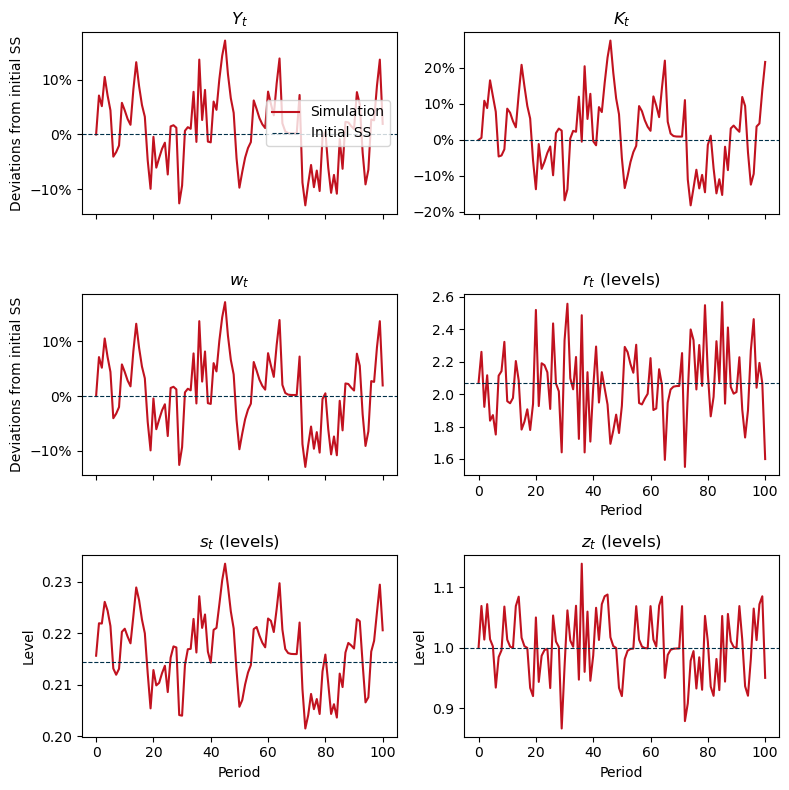

In [104]:
# Plot the transition dynamics of the OLG model with AR(1) TFP
plot_simulation(eq_paygo, sim_ar1)

### **Explanation of the results**
The plots illustrate the transition dynamics of key economic variables in the Overlapping Generations (OLG) model with aggregate risk, where log TFP follows an AR(1) process. The introduction of stochastic TFP ($z_t$) generates persistent fluctuations around the steady-state values. The top-left panel shows that output ($Y_t$) exhibits volatility, driven by TFP fluctuations that affect production. Similarly, the top-right panel shows capital ($K_t$), which responds endogenously to TFP-driven changes in savings and investment. The middle-left panel illustrates the wage rate ($w_t$), which co-moves with output and capital, reflecting labor productivity changes. The middle-right panel shows the interest rate ($r_t$), which varies inversely with capital accumulation—rising when capital is low and falling when capital is abundant. The bottom-left panel presents the savings rate ($s_t$), which fluctuates in response to both wage and interest rate dynamics. Lastly, the bottom-right panel confirms that TFP ($z_t$) follows an AR(1) process. Overall, these plots demonstrate how aggregate risk spreads through the economy, causing temporary deviations from steady-state values, yet maintaining long-run stability around equilibrium.

***
# ***Part 7 - Changing the volatility of TFP***
***

In [105]:
# Rerun simulation for T = 10 000 periods, for a grid of 11 sigma values which are uniformly spaced between 0.0 and 0.1
T = 10_000

# Create a grid of sigma values
sigma_grid = np.linspace(0.0, 0.1, 11)

# Prepare arrays to store the deviations from the initial steady state for each sigma value
devK_vals = np.zeros(len(sigma_grid))
devs_vals = np.zeros(len(sigma_grid))

# Steady state values
K_star = eq_paygo.K
s_star = eq_paygo.s

In [106]:
# Loop over each sigma value
for i, sigma in enumerate(sigma_grid):
    
    # For each sigma, set the variance
    par_paygo.sigma_2 = sigma**2
    par_paygo.mu = -0.5*par_paygo.sigma_2 / (1 - par_paygo.rho) # Ensures that mu also is updated with the new sigma

    # Simulate TFP
    z_series = simulate_ar1(z0, T, seed, par_paygo)

    # Simulate OLG model (start at SS capital or some chosen initial K)
    sim = simulate_olg_ar1(K_star, z_series, par_paygo)

    # Compute average capital & savings
    K_bar = np.mean(sim.K)
    s_bar = np.mean(sim.s)

    # Compute percent deviations from the new SS
    devK_vals[i] = 100 * (K_bar / K_star - 1)
    devs_vals[i] = 100 * (s_bar / s_star - 1)

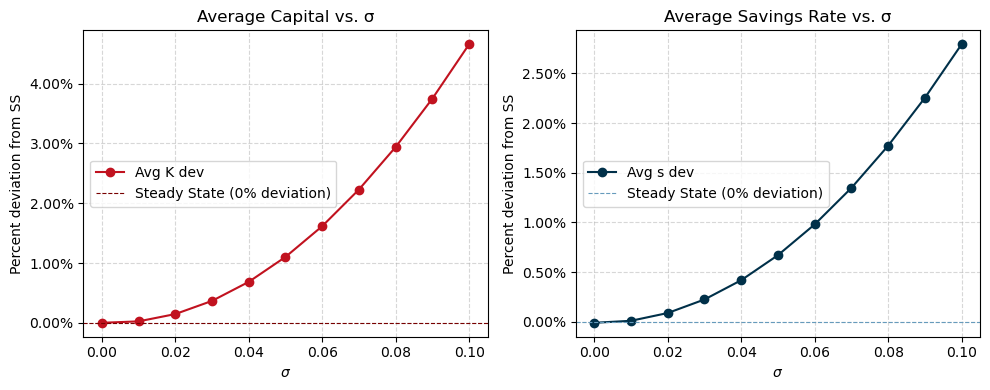

In [107]:
# Plot the results  
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: capital deviations
axes[0].plot(sigma_grid, devK_vals, marker='o', label="Avg K dev", c = colors[0])
axes[0].axhline(0, c = colors[1], ls='--', lw=0.8, label = "Steady State (0% deviation)")
axes[0].set_xlabel(r"$\sigma$")
axes[0].set_ylabel("Percent deviation from SS")
axes[0].set_title("Average Capital vs. σ")
axes[0].legend(loc = 'center left')
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=2))

# Right: savings deviations
axes[1].plot(sigma_grid, devs_vals, marker='o', c = colors[2], label="Avg s dev")
axes[1].axhline(0, c = colors[3], ls='--', lw=0.8, label = "Steady State (0% deviation)")
axes[1].set_xlabel(r"$\sigma$")
axes[1].set_ylabel("Percent deviation from SS")
axes[1].set_title("Average Savings Rate vs. σ")
axes[1].legend(loc = 'center left')
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].yaxis.set_major_formatter(PercentFormatter(decimals=2))

plt.tight_layout()

### **Explanation of the results**
As $\sigma$ increases, both $K$ and $s$ rise above their deterministic steady state levels. The upward slopes indicate that households save more and accumulate more capital under higher uncertainty.

<ins> **Economic intuition:**</ins>
- Greater Uncertainty $\rightarrow$ Higher Saving: Faced with riskier future income, risk‐averse households save more to protect against bad shocks.
- More Saving $\rightarrow$ Larger Capital Stock: Because saving translates into investment, a higher saving rate increases the average capital stock in the economy.

In short, increased TFP volatility induces households to save more, leading to higher capital accumulation. This is a classic precautionary saving response to uncertainty.


**NB**: When $\sigma = 0 \Rightarrow z = 0$.  Since we simulate over $T = 100 000$ periods, the average $K$ and $s$ are very close to their deterministic steady state values, leading to approximately $0%$ deviations from the those levels.